<a href="https://colab.research.google.com/github/GerGoar/Image_Deep_Learning_Project/blob/main/Stable_Diffusion_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation

In [1]:
!pip install -U diffusers[training] #in case collab resets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      S

In [2]:
from huggingface_hub import notebook_login

notebook_login()

!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

📷 Generating images BEFORE fine-tuning...



  0%|          | 0/50 [00:00<?, ?it/s]

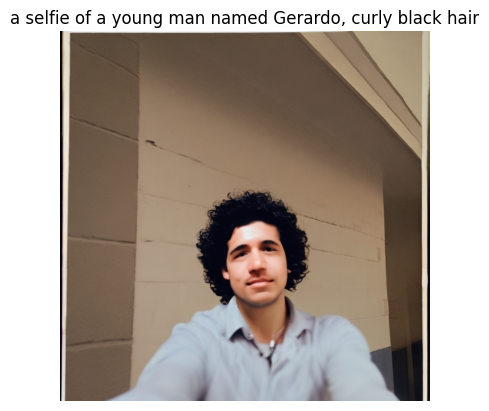

  0%|          | 0/50 [00:00<?, ?it/s]

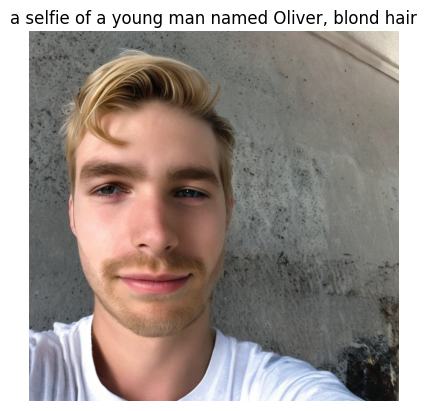

  0%|          | 0/50 [00:00<?, ?it/s]

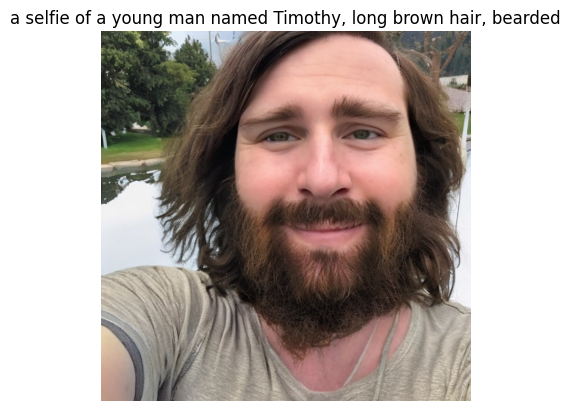

In [7]:
name_to_prompt = {
    "Gerardo": "a selfie of a young man named Gerardo, curly black hair",
    "Oliver": "a selfie of a young man named Oliver, blond hair",
    "Timothy": "a selfie of a young man named Timothy, long brown hair, bearded"
}

# Load base model
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to("cuda")
pipe.text_encoder.eval()

def generate_and_show(prompt, filename):
    with torch.autocast("cuda"):
        image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save(filename)
    plt.imshow(image)
    plt.axis("off")
    plt.title(prompt)
    plt.show()

# 🔹 BEFORE fine-tuning
print("Generating images BEFORE fine-tuning...\n")
for name, prompt in name_to_prompt.items():
    generate_and_show(prompt, f"before_{name.lower()}.png")

## Creating the Images, Inspecting quality

In [8]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to("cuda")
pipe.unet.load_attn_procs("otausendschoen/sd21-faces-lora")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generating images BEFORE fine-tuning...



  0%|          | 0/50 [00:00<?, ?it/s]

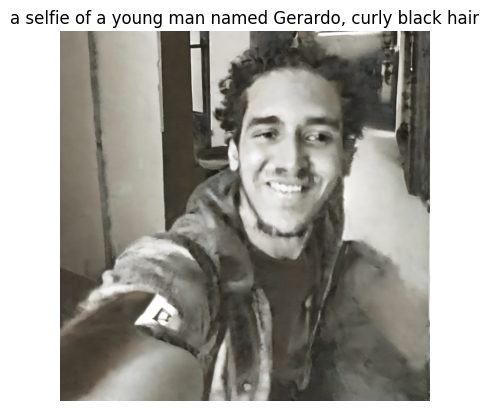

  0%|          | 0/50 [00:00<?, ?it/s]

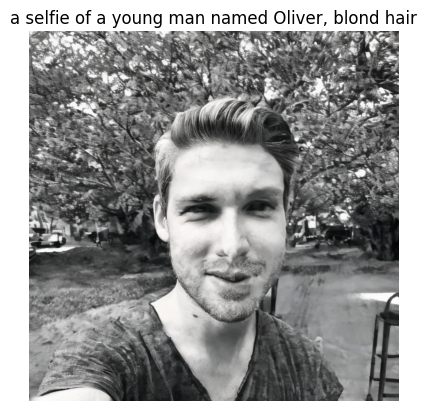

  0%|          | 0/50 [00:00<?, ?it/s]

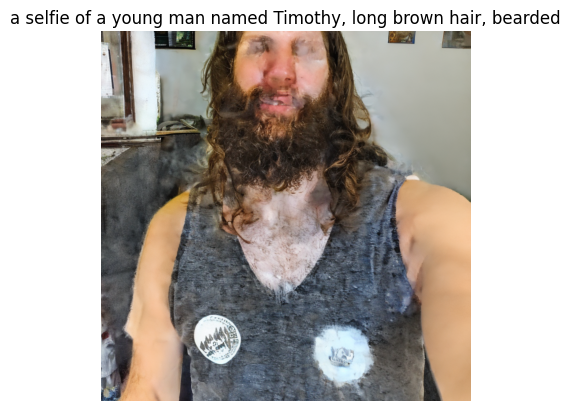

In [9]:

def generate_and_show(prompt, filename):
    with torch.autocast("cuda"):
        image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save(filename)
    plt.imshow(image)
    plt.axis("off")
    plt.title(prompt)
    plt.show()

# 🔹 BEFORE fine-tuning
print("Generating images BEFORE fine-tuning...\n")
for name, prompt in name_to_prompt.items():
    generate_and_show(prompt, f"after_{name.lower()}.png")

## CONTINUE HERE

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def generate_class_conditional_images(model, noise_scheduler, class_labels, image_size=64, seed=42):
    model.eval()
    batch_size = len(class_labels)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    x = torch.randn(batch_size, 3, image_size, image_size, device="cuda", generator=generator)
    ##REVERSE DIFFUSION:
#new loop with few timesteps
    for t in noise_scheduler.timesteps:
      timesteps = torch.full((batch_size,), t, device="cuda", dtype=torch.long)
      with torch.no_grad():
        noise_pred = model(x, timesteps, class_labels=class_labels).sample
      x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images

'''
#old loop with original timestpes
    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device='cuda:0'))

    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)
        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above
        with torch.no_grad():
            noise_pred = model(x, timesteps, class_labels=class_labels).sample
        x = noise_scheduler.step(noise_pred, t, x).prev_sample
    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images
'''


'\n#old loop with original timestpes\n    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device=\'cuda:0\'))\n\n    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)\n        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above\n        with torch.no_grad():\n            noise_pred = model(x, timesteps, class_labels=class_labels).sample\n        x = noise_scheduler.step(noise_pred, t, x).prev_sample\n    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images\n'

🕒 100 Timesteps: Image generation took 9.09 seconds (0.15 minutes)


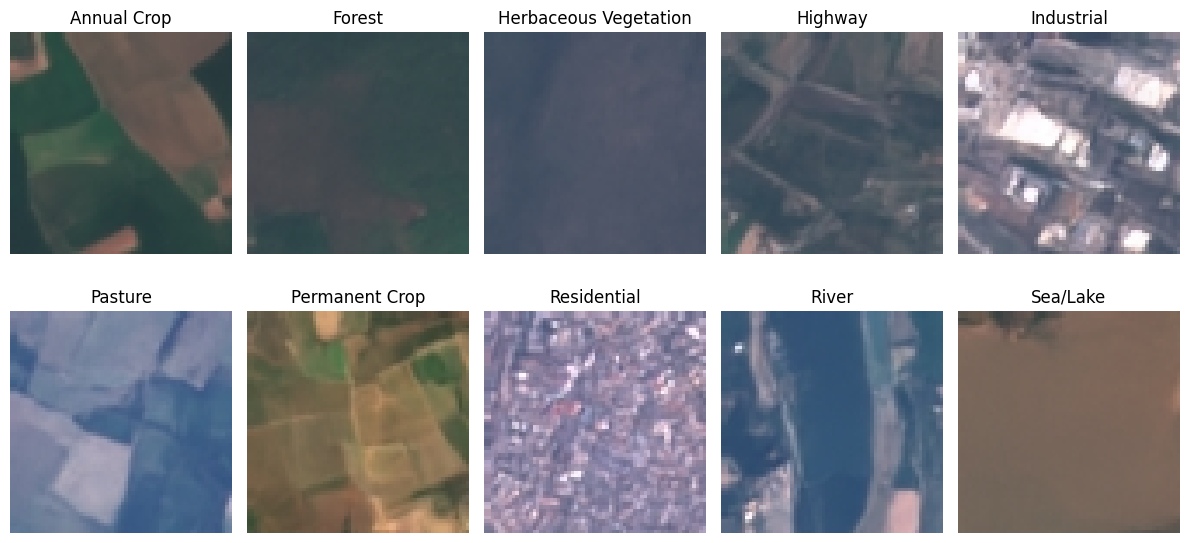

In [ ]:
noise_scheduler.set_timesteps(100)  # Sample using only 200 steps!

labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device="cuda")


start_time = time.time()
images = generate_class_conditional_images(model, noise_scheduler, class_labels=labels)
end_time = time.time()

elapsed = end_time - start_time
print(f"🕒 100 Timesteps: Image generation took {elapsed:.2f} seconds ({elapsed / 60:.2f} minutes)")#

batch_size = len(labels)



eurosat_classes = [
    "Annual Crop", "Forest", "Herbaceous Vegetation", "Highway",
    "Industrial", "Pasture", "Permanent Crop", "Residential",
    "River", "Sea/Lake"
]

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(batch_size):
    img = transforms.ToPILImage()(images[i].cpu())
    class_name = eurosat_classes[labels[i].item()]
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(class_name)
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()



## Mass Upload

In [ ]:
import os
def get_last_index(folder):
    """Returns the max image index found in folder, or -1 if empty."""
    if not os.path.exists(folder):
        print(f"Folder does not exist: {folder}")
        return -1

    files = [f for f in os.listdir(folder) if f.endswith(".jpg")]
    if not files:
        print(f" Folder exists but has no .jpg files: {folder}")
        return -1

    indices = []
    for fname in files:
        try:
            index = int(fname.split(".")[0])
            indices.append(index)
        except ValueError:
            continue

    return max(indices) if indices else -1


Now let's safe them inside the output folder instead of plotting them:

In [ ]:
import torch
from torchvision.utils import save_image
from tqdm import tqdm
import os

def generate_class_conditional_images(model, noise_scheduler, num_images=5000, image_size=64, device="cuda"):
    eurosat_classes = [
        "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
        "Industrial", "Pasture", "PermanentCrop", "Residential",
        "River", "SeaLake"
    ]

    model.eval()
    images_to_generate = num_images // 10  # generate this many *new* images per class
    batch_size = 200
    os.makedirs("output", exist_ok=True)

    for label in tqdm(range(10), desc="Generating classes"):
        output_dir = os.path.join("output", eurosat_classes[label])
        os.makedirs(output_dir, exist_ok=True)

        start_idx = get_last_index(output_dir) + 1
        print(f"{eurosat_classes[label]} has {start_idx} images — generating {images_to_generate} more (→ total {start_idx + images_to_generate})")

        num_batches = (images_to_generate + batch_size - 1) // batch_size

        for batch_idx in tqdm(range(num_batches), desc=f"Class {eurosat_classes[label]}", leave=True):
            generator = torch.Generator(device=device).manual_seed(label * 100 + batch_idx + start_idx // batch_size)
            noise = torch.randn(batch_size, 3, image_size, image_size, device=device, generator=generator)
            class_labels = torch.full((batch_size,), label, device=device, dtype=torch.long)

            x = noise
            for t in noise_scheduler.timesteps:
                timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
                with torch.no_grad():
                    noise_pred = model(x, timesteps, class_labels=class_labels).sample
                x = noise_scheduler.step(noise_pred, t, x).prev_sample

            x = (x / 2 + 0.5).clamp(0, 1)

            for i in range(batch_size):
                img_idx = start_idx + batch_idx * batch_size + i
                if i + batch_idx * batch_size >= images_to_generate:
                    break
                save_path = os.path.join(output_dir, f"{img_idx}.jpg")
                save_image(x[i], save_path)

    print("All new images generated and saved.")


To continue generating:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
#unzip archive

shutil.unpack_archive("/content/drive/MyDrive/data/ddpm-generated-images.zip", "/content/output")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
generate_class_conditional_images(model, noise_scheduler)

Generating classes:   0%|          | 0/10 [00:00<?, ?it/s]

AnnualCrop has 2600 images — generating 500 more (→ total 3100)



Generating classes:  10%|█         | 1/10 [08:23<1:15:31, 503.53s/it]

Forest has 2600 images — generating 500 more (→ total 3100)



Generating classes:  20%|██        | 2/10 [16:46<1:07:06, 503.34s/it]

HerbaceousVegetation has 2600 images — generating 500 more (→ total 3100)



Generating classes:  30%|███       | 3/10 [25:10<58:43, 503.32s/it]  

Highway has 2600 images — generating 500 more (→ total 3100)



Generating classes:  40%|████      | 4/10 [33:33<50:19, 503.30s/it]

Industrial has 2600 images — generating 500 more (→ total 3100)



Generating classes:  50%|█████     | 5/10 [41:56<41:56, 503.31s/it]

Pasture has 2600 images — generating 500 more (→ total 3100)



Generating classes:  60%|██████    | 6/10 [50:19<33:33, 503.26s/it]

PermanentCrop has 2600 images — generating 500 more (→ total 3100)



Generating classes:  70%|███████   | 7/10 [58:41<25:07, 502.64s/it]

Residential has 2600 images — generating 500 more (→ total 3100)



Generating classes:  80%|████████  | 8/10 [1:07:04<16:45, 502.74s/it]

River has 2600 images — generating 500 more (→ total 3100)



Generating classes:  90%|█████████ | 9/10 [1:15:27<08:23, 503.00s/it]

SeaLake has 2600 images — generating 500 more (→ total 3100)



Generating classes: 100%|██████████| 10/10 [1:23:51<00:00, 503.10s/it]

All new images generated and saved.


**Uploading to drive**

In [ ]:
import shutil
# Archive the folder
shutil.make_archive("ddpm-generated-images", 'zip', 'output')
print(os.path.exists("ddpm-generated-images.zip"))  # Should print: True
print(os.path.exists("/content/drive/MyDrive/data"))
# Define destination path
destination = "/content/drive/MyDrive/data/ddpm-generated-images.zip"



# Move the file
shutil.move("ddpm-generated-images.zip", destination)
print(f"Archive moved to: {destination}")

True
True
Archive moved to: /content/drive/MyDrive/data/ddpm-generated-images.zip


In [ ]:
categories = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway",
    "Industrial", "Pasture", "PermanentCrop", "Residential",
    "River", "SeaLake"
]

# Count total images in all output subdirectories
total_images = 0
output_dir = 'output'

# Loop through each category folder and count images
for category in categories:
    category_path = os.path.join(output_dir, category)
    if os.path.exists(category_path):
        category_count = 0
        for root, dirs, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    category_count += 1
                    total_images += 1
        print(f"Images in {category}: {category_count}")

Images in AnnualCrop: 3100
Images in Forest: 3100
Images in HerbaceousVegetation: 3100
Images in Highway: 3100
Images in Industrial: 3100
Images in Pasture: 3100
Images in PermanentCrop: 3100
Images in Residential: 3100
Images in River: 3100
Images in SeaLake: 3100
